# TensorFlow 2 quickstart for experts

Import TensorFlow into your program:

In [75]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

TensorFlow version: 2.10.0


Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

In [76]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

print("x_train {}, x_test {}".format(x_train.shape, x_test.shape))

x_train (60000, 28, 28, 1), x_test (10000, 28, 28, 1)


Use `tf.data` to batch and shuffle the dataset:

In [77]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models):

In [78]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

Choose an optimizer and loss function for training: 

These are the same loss_object and optimizer as for the CIFAR10 model.

In [79]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [80]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Use `tf.GradientTape` to train the model:

In [81]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

Test the model:

In [82]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [83]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.13859020173549652, Accuracy: 95.80166625976562, Test Loss: 0.0620482861995697, Test Accuracy: 97.83999633789062
Epoch 2, Loss: 0.04388544335961342, Accuracy: 98.5816650390625, Test Loss: 0.053345292806625366, Test Accuracy: 98.36000061035156
Epoch 3, Loss: 0.02268223464488983, Accuracy: 99.2933349609375, Test Loss: 0.05391532927751541, Test Accuracy: 98.2699966430664
Epoch 4, Loss: 0.012941479682922363, Accuracy: 99.54833221435547, Test Loss: 0.06045481562614441, Test Accuracy: 98.2699966430664
Epoch 5, Loss: 0.010176856070756912, Accuracy: 99.69499969482422, Test Loss: 0.06388391554355621, Test Accuracy: 98.37999725341797


INFO:tensorflow:Assets written to: ./mnist_model\assets


INFO:tensorflow:Assets written to: ./mnist_model\assets


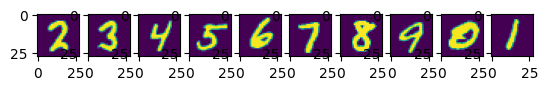

In [84]:
import matplotlib.pyplot as plt
import math as math

def plot_images(images, n = 10):
    fig = plt.figure()
    plot = None
    for index in map(lambda i: i+1, range(n)):
        fig.add_subplot(1,n,index)
        plot = plt.imshow(test_images[index])

plot_images(test_images, 10)

model.save("./mnist_model")

In [118]:
# load the model
import numpy as np
from tensorflow import keras as keras
mnist_model = keras.models.load_model("./mnist_model/")

# print the model summary
mnist_model.summary()

Model: "my_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           multiple                  320       
                                                                 
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 dense_10 (Dense)            multiple                  2769024   
                                                                 
 dense_11 (Dense)            multiple                  1290      
                                                                 
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________


The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials).

In [119]:
# use the model to predict

def predict(input, index):
    predictions = mnist_model.predict(input)[index]
    predictions_norm = np.linalg.norm(predictions)
    normalized_predictions = abs(predictions / predictions_norm)
    
    return "label={}, confidence={}".format(normalized_predictions.tolist().index(normalized_predictions.max()), normalized_predictions.max())

predict(test_images, 0)

1/1 [==============================] - 0s 183ms/step


'label=1, confidence=0.6421177387237549'